# Lab 4 Introduction to Function Generator Usage and Reactive Components

This jupyter notebook intends to simulate the circuits used in the lab to produce the expected lab results. Circuit component measurements are used to recreate the components used in the lab.

**IMPORTANT:** Circuit simulations are done through [`Ngspice`](https://ngspice.sourceforge.io/), and the results are interpreted through the scripts written in this notebook. If you wish to run this notebook on your own, you will need to [download and install](https://ngspice.sourceforge.io/download.html) `Ngspice` for the command line. Run this notebook by executing each code block sequentially, or simply click "Run All" if that option is available.

**NOTE:** The experiments below correspond to the lab 4 document from February 26th, 2024, and has changed since then.

# Environment setup

This notebook will use the current working directory (CWD) to save data outputted by the simulations. To reduce the number of required accompanying files, the circuit files are saved as strings under each lab experiment section. This requires some auxiliary functions shown below:

In [1]:
## File Handling and Ngspice Execution
import subprocess

from pathlib import Path

def tmp_file(contents, filename='tmp.cir', overwrite=True):
    """Save contents to a temporary file."""
    file_path = Path.cwd() / filename
    mode = 'w' if file_path.is_file() and overwrite else 'x'
    
    with open(filename, mode) as file:
        file.write(contents)
        file.close()
    return filename

def run_ngspice(file, capture=False):
    """Execute Ngspice with a file."""
    subprocess.run(f"ngspice {file}".split(),
                   stdout=subprocess.PIPE if capture else subprocess.DEVNULL,
                   stderr=subprocess.PIPE if capture else subprocess.DEVNULL)

## Experiment 2: Capacitor/Frequency Relationship

Experiment 2 uses an RC circuit described with the file below. As mentioned in the beginning, some circuit components are using the measurements of the in-lab components.

In [2]:
exp2_wave_file = 'exp2_wave.txt'
exp2_attr_file = 'exp2_attr.txt'

exp2_spice_file = (
    'Lab4e2\n'
    '\n'
    'VIN in 0 dc 0 ac 1 SIN(0 2.5 15K)\n'
    'R1 in out 98.25\n'
    'C1 out 0 98.6NF\n'
    '\n'
    '.control\n'
    'tran 1u 100u\n'
    f'wrdata {exp2_wave_file} vr(in) vr(out)\n'
    'ac lin 500 0.1KHZ 500KHZ\n'
    f'wrdata {exp2_attr_file} vr(out) ph(out)\n'
    '.endc\n'
    '.end\n'
)

We first execute the circuit file with `Ngspice`. The results are saved in text files with values separated by spaces which we save into a DataFrame.

In [3]:
import pandas as pd

run_ngspice(tmp_file(exp2_spice_file))

exp2_wave = pd.read_csv(exp2_wave_file, sep=r'\s+', header=None)
exp2_attr = pd.read_csv(exp2_attr_file, sep=r'\s+', header=None)

Next, the data needs to be processed. The real voltage is normalized to the source amplitude, while the phase is in radians. Additionally, the lab report calls for measurements at specific frequencies. We need to extract those frequencies from our data.

In [4]:
import numpy as np

def find_nearest(array, value):
    # https://stackoverflow.com/a/2566508
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

## Preprocessing the AC attributes data
# Convert data to proper units
frequency2 = exp2_attr[0]
voltage2 = exp2_attr[1] * 5
phase2 = exp2_attr[3] * -180 / np.pi

time2 = exp2_wave[0]
channel12 = exp2_wave[1]
channel22 = exp2_wave[3]

# Collect data at desired frequencies
select_frequency2 = np.array([0.1, 1, 5, 10, 15, 20, 25, 50, 100, 500]) * 1e3
select_phase2 = []
select_voltage2 = []

for f in select_frequency2:
    i, _ = find_nearest(frequency2, f)
    select_voltage2.append(voltage2[i])
    select_phase2.append(phase2[i])

select_phase2 = np.array(select_phase2)
select_voltage2 = np.array(select_voltage2)

Finally, the data is ready to be presented and visualized:

  frequency     voltage      phase
-----------  ----------  ---------
        100  4.99981      0.348744
       1000  4.97761      3.83677
       5000  4.55911     17.2744
      10000  3.62505     31.6275
      15000  2.70594     42.6375
      20000  1.99824     50.7891
      25000  1.49587     56.8407
      50000  0.483892    71.8749
     100000  0.130694    80.6959
     500000  0.00539241  88.1181


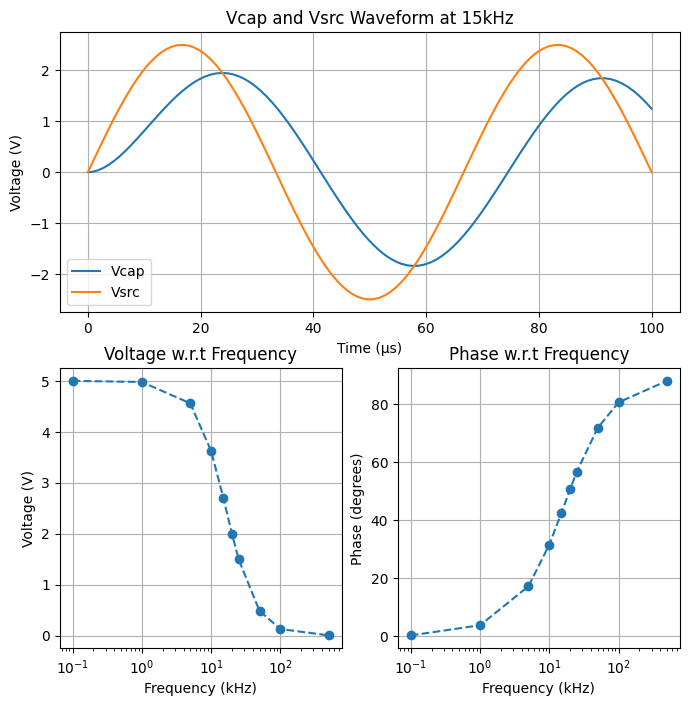

In [5]:
import matplotlib.pyplot as plt

from tabulate import tabulate

table = np.array((select_frequency2, select_voltage2, select_phase2)).T
print(tabulate(table, headers=('frequency', 'voltage', 'phase')))

fig = plt.figure(figsize=(8, 8))

ax0 = fig.add_subplot(2, 2, (1, 2))
ax0.plot(time2*1e6, channel22, label='Vcap')
ax0.plot(time2*1e6, channel12, label='Vsrc')
ax0.set_title("Vcap and Vsrc Waveform at 15kHz")
ax0.set_xlabel("Time (\u03bcs)")
ax0.set_ylabel("Voltage (V)")
ax0.legend()
ax0.grid(True)

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(select_frequency2 / 1e3, select_voltage2, '--o')
ax2.set_xscale('log')
ax2.set_title("Voltage w.r.t Frequency")
ax2.set_xlabel("Frequency (kHz)")
ax2.set_ylabel("Voltage (V)")
ax2.grid(True)

ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(select_frequency2 / 1e3, select_phase2, '--o')
ax3.set_xscale('log')
ax3.set_title("Phase w.r.t Frequency")
ax3.set_xlabel("Frequency (kHz)")
ax3.set_ylabel("Phase (degrees)")
ax3.grid(True)

plt.show()

## Experiment 3: Inductor/Frequency Relationship

This experiment works the exact same way as the previous experiment.

  frequency      voltage     phase
-----------  -----------  --------
        100  2.04486e-06  -89.9634
       1000  0.000165924  -89.6699
       5000  0.00491453   -88.2034
      10000  0.0200012    -86.3738
      15000  0.0450783    -84.5515
      20000  0.0798445    -82.7402
      25000  0.123889     -80.9434
      50000  0.462953     -72.2847
     100000  1.45132      -57.4007


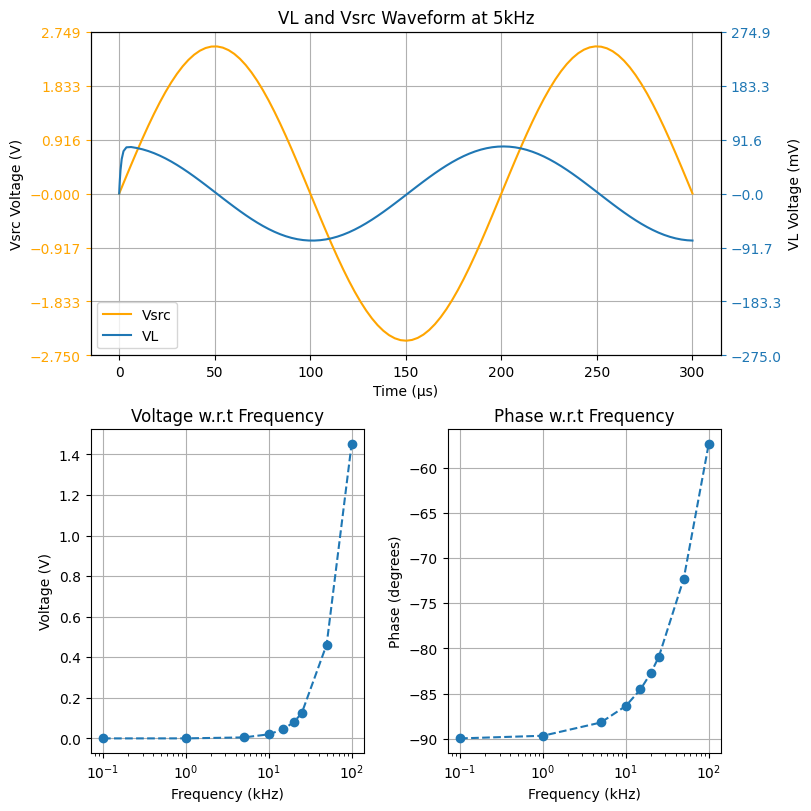

In [6]:
# Experiment 3
import matplotlib.ticker

# Ngspice simulation
exp3_wave_file = 'exp3_wave.txt'
exp3_attr_file = 'exp3_attr.txt'

exp3_spice_file = (
    'Lab4e3\n'
    '\n'
    'VIN in 0 dc 0 ac 1 SIN(0 2.5 5K)\n'
    'R1 in out 98.25\n'
    'L1 out 0 100UH\n'
    '\n'
    '.control\n'
    'tran 3u 300u\n'
    f'wrdata {exp3_wave_file} vr(in) vr(out)\n'
    'ac lin 500 0.1KHZ 100KHZ\n'
    f'wrdata {exp3_attr_file} vr(out) ph(out)\n'
    '.endc\n'
    '.end'
)

run_ngspice(tmp_file(exp3_spice_file))

exp3_wave = pd.read_csv(exp3_wave_file, sep=r'\s+', header=None)
exp3_attr = pd.read_csv(exp3_attr_file, sep=r'\s+', header=None)

# Data processing
frequency3 = exp3_attr[0]
voltage3 = exp3_attr[1] * 5
phase3 = exp3_attr[3] * -180 / np.pi

time3 = exp3_wave[0]
channel13 = exp3_wave[1]
channel23 = exp3_wave[3]

# Collect data at desired frequencies
select_frequency3 = np.array([0.1, 1, 5, 10, 15, 20, 25, 50, 100]) * 1e3
select_phase3 = []
select_voltage3 = []

for f in select_frequency3:
    i, _ = find_nearest(frequency3, f)
    select_voltage3.append(voltage3[i])
    select_phase3.append(phase3[i])

select_phase3 = np.array(select_phase3)
select_voltage3 = np.array(select_voltage3)

# Displaying results
table = np.array((select_frequency3, select_voltage3, select_phase3)).T
print(tabulate(table, headers=('frequency', 'voltage', 'phase')))

fig = plt.figure(layout='constrained', figsize=(8, 8))
ticks = np.linspace(1.1*np.min(channel13), 1.1*np.max(channel13), 7)

ax0 = fig.add_subplot(2, 2, (1, 2))
line1 = ax0.plot(time3*1e6, channel13, color='orange', label='Vsrc')
ax0.set_yticks(ticks)
ax0.tick_params('y', colors='orange')
ax0.set_title("VL and Vsrc Waveform at 5kHz")
ax0.set_xlabel("Time (\u03bcs)")
ax0.set_ylabel("Vsrc Voltage (V)")

# Channel 2 does not plot well with Channel 1,
# so it will be plotted on separate axes.
ax1 = ax0.twinx()
line2 = ax1.plot(time3*1e6, channel23*1e3, label='VL')
ax1.set_yticks(ticks*100)
ax1.tick_params('y', colors='tab:blue')
ax1.set_ylabel("VL Voltage (mV)")

ax0.grid(True)

# https://stackoverflow.com/a/5487005
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax0.legend(lines, labels, loc=0)

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(select_frequency3 / 1e3, select_voltage3, '--o')
ax2.set_xscale('log')
ax2.set_title("Voltage w.r.t Frequency")
ax2.set_xlabel("Frequency (kHz)")
ax2.set_ylabel("Voltage (V)")
ax2.grid(True)

ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(select_frequency3 / 1e3, select_phase3, '--o')
ax3.set_xscale('log')
ax3.set_title("Phase w.r.t Frequency")
ax3.set_xlabel("Frequency (kHz)")
ax3.set_ylabel("Phase (degrees)")
ax3.grid(True)

plt.show()

## Experiment 4: RLC Circuit

This experiments places the capacitor and inductor in parallel. Strangely, the lab requires a capacitor (22nF) that is not available with the given lab kit. Even more strangely, such a circuit with a 22nF capacitor would not demonstrate anything of significance within the circuit, and the use of a 10k&#x03a9; resistor does not allow the two other elements to have an affect on each other. For this simulation, a 22&#x03bc;F capacitor and 100&#x03a9; resistor is used instead.

The process of simulating to visualizing the experiment is identical to the previous experiments.

  frequency      voltage     phase
-----------  -----------  --------
        100  2.04487e-06  -89.9634
       1000  0.00023212   -89.6096
       5000  0.00639637   -87.9503
      10000  0.0165869    -86.6981
      15000  0.0434588    -84.6506
      20000  0.0709295    -83.1596
      25000  0.116948     -81.2029
      50000  0.605357     -69.6378
     100000  4.47571      -18.894
     500000  0.116382      81.2243


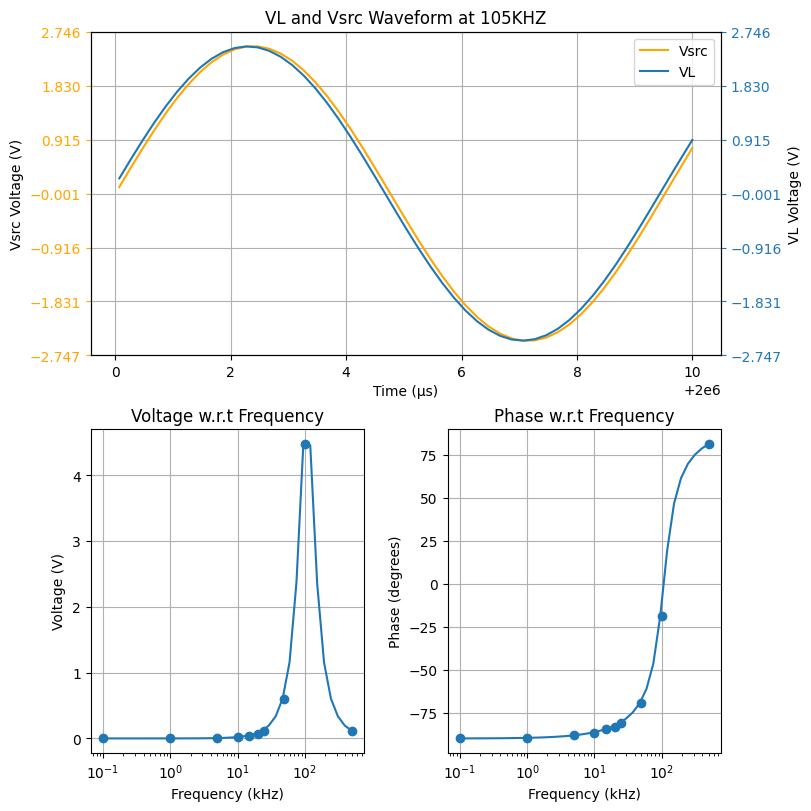

In [30]:
# Experiment 4

old = False
ac = 'ac lin 500 0.5KHZ 6.5KHZ' if old else 'ac dec 10 0.1KHZ 500KHZ'
transient = 'tran 3u 5000.6ms 5s' if old else 'tran 3u 2000.01ms 2s'
C1 = '22uF' if old else '22nF'
frequency = '3.4KHZ' if old else '105KHZ'

exp4_wave_file = 'exp4_wave.txt'
exp4_attr_file = 'exp4_attr.txt'

exp4_spice_file = (
    'Lab4e4\n'
    '\n'
    f'VIN in 0 dc 0 ac 1 SIN(0 2.5 {frequency})\n'
    'R1 in out 98.25\n'
    f'C1 out 0 {C1}\n'
    'L1 out 0 100UH\n'
    '\n'
    '.control\n'
    f'{transient}\n'
    f'wrdata {exp4_wave_file} vr(in) vr(out)\n'
    f'{ac}\n'
    f'wrdata {exp4_attr_file} vr(out) ph(out)\n'
    '.endc\n'
    '.end'
)

run_ngspice(tmp_file(exp4_spice_file))

exp4_wave = pd.read_csv(exp4_wave_file, sep=r'\s+', header=None)
exp4_attr = pd.read_csv(exp4_attr_file, sep=r'\s+', header=None)

# Data processing
frequency4 = exp4_attr[0]
voltage4 = exp4_attr[1] * 5
phase4 = exp4_attr[3] * -180 / np.pi

time4 = exp4_wave[0]
channel14 = exp4_wave[1]
channel24 = exp4_wave[3]

# Collect data at desired frequencies
if old:
    select_frequency4 = np.array([
        0.5, 1.0, 1.5, 2.0,
        3.0, 3.1, 3.2, 3.4,
        3.6, 3.8, 4.0, 4.5,
        5.0, 5.5, 6.0, 6.5
    ]) * 1e3
else:
    select_frequency4 = np.array([0.1, 1, 5, 10, 15, 20, 25, 50, 100, 500]) * 1e3
select_phase4 = []
select_voltage4 = []

for f in select_frequency4:
    i, _ = find_nearest(frequency4, f)
    select_voltage4.append(voltage4[i])
    select_phase4.append(phase4[i])

select_phase4 = np.array(select_phase4)
select_voltage4 = np.array(select_voltage4)

# Displaying results
table = np.array((select_frequency4, select_voltage4, select_phase4)).T
print(tabulate(table, headers=('frequency', 'voltage', 'phase')))

fig = plt.figure(layout='constrained', figsize=(8, 8))
ticks = np.linspace(1.1*np.min(channel14), 1.1*np.max(channel14), 7)

ax0 = fig.add_subplot(2, 2, (1, 2))
line1 = ax0.plot(time4*1e6, channel14, color='orange', label='Vsrc')
ax0.set_yticks(ticks)
ax0.tick_params('y', colors='orange')
ax0.set_title(f"VL and Vsrc Waveform at {frequency}")
ax0.set_xlabel("Time (\u03bcs)")
ax0.set_ylabel("Vsrc Voltage (V)")

# Channel 2 does not plot well with Channel 1,
# so it will be plotted on separate axes.
ax1 = ax0.twinx()
line2 = ax1.plot(time4*1e6, channel24, label='VL')
ax1.set_yticks(ticks)
ax1.tick_params('y', colors='tab:blue')
ax1.set_ylabel("VL Voltage (V)")

ax0.grid(True)

# https://stackoverflow.com/a/5487005
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax0.legend(lines, labels, loc=0)

ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(select_frequency4 / 1e3, select_voltage4, 'o')
ax2.plot(frequency4 / 1e3, voltage4, '-', color='tab:blue')
ax2.set_xscale('log')
ax2.set_title("Voltage w.r.t Frequency")
ax2.set_xlabel("Frequency (kHz)")
ax2.set_ylabel("Voltage (V)")
ax2.grid(True)

ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(select_frequency4 / 1e3, select_phase4, 'o')
ax3.plot(frequency4 / 1e3, phase4, '-', color='tab:blue')
ax3.set_xscale('log')
ax3.set_title("Phase w.r.t Frequency")
ax3.set_xlabel("Frequency (kHz)")
ax3.set_ylabel("Phase (degrees)")
ax3.grid(True)

plt.show()